In [2]:
import pandas as pd
df = pd.read_csv('./data/sales_train.csv').dropna()[['unique_id', 'date', 'sales', 'warehouse']]
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '06-01-2022']

df['city'] = df['warehouse'].apply(lambda x: x.split('_')[0])
df['dayofweek'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year

df['sales'] = np.sqrt(df['sell_price_main'] * df['sales'])

NameError: name 'np' is not defined

In [2]:
week_encoding = df[['dayofweek', 'sales', 'city', 'year']].groupby(['year', 'dayofweek', 'city']).mean().reset_index()
week_mean = df[['sales', 'city', 'year']].groupby(['year', 'city']).mean().reset_index()
week_mean.rename(columns={'sales': 'mean_sales'}, inplace=True)
week_encoding.rename(columns={'sales': 'weekday_avg_sales'}, inplace=True)
week_encoding = week_encoding.merge(week_mean, how='left', on=['city', 'year'])
week_encoding['weekday_frac_sales'] = week_encoding['weekday_avg_sales'] / week_encoding['mean_sales']
week_encoding.drop('mean_sales', axis=1, inplace=True)

df = df.merge(week_encoding, how='left', on=['year', 'dayofweek', 'city'])

df = df.sort_values(['unique_id', 'date'])

df['moving'] = df[['unique_id', 'sales']].groupby('unique_id')\
    .shift(14).rolling(window=14, min_periods=1).mean().fillna(0).reset_index()['sales']

df['week_trend'] = df['weekday_frac_sales'] * df['moving']

In [3]:
id = 4845
dfid = df.loc[df['unique_id'] == id, ['date', 'sales']]
dfid = dfid.sort_values('date')
dfid['moving'] = dfid['sales']\
    .shift(14).rolling(window=14, min_periods=1).mean().fillna(0)

import numpy as np
dfid['cos_weekday'] = np.cos(2 * np.pi * dfid['date'].dt.weekday / 7)
dfid['sin_weekday'] = np.sin(2 * np.pi * dfid['date'].dt.weekday / 7)
PERIODS = list(range(1,15)) + [17, 21, 28, 35, 42]
for shift in PERIODS:
    dfid[f'lag_{shift}'] = dfid['sales'].shift(periods=shift).fillna(0)

In [4]:
import cvxpy as cp
import numpy as np

cols = ['moving', 'cos_weekday', 'sin_weekday'] + [f'lag_{lag}' for lag in PERIODS]

n, p = len(dfid), len(cols)
X = dfid[cols].to_numpy()
y = dfid['sales'].to_numpy()

# Define CVXPY variables
beta = cp.Variable(p)  # Regression coefficients
c = cp.Variable()
xi = cp.Variable(n)  # Auxiliary variables for absolute values

# Constraints for absolute value reformulation
constraints = [
    xi >= y - X @ beta - c,
    xi >= -(y - X @ beta - c)
]

# Objective: Minimize weighted sum of absolute errors
objective = cp.Minimize(cp.mean(xi))

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimized coefficients
beta_opt = beta.value
for (col, beta) in zip(cols, beta_opt):
    print(f'{col:10}', beta)
print(f'constant   {c.value}')

moving     0.17269583070460115
cos_weekday -0.7377607794994653
sin_weekday 1.1031436333826867
lag_1      0.06812392808005936
lag_2      0.05365694312863908
lag_3      0.03111891096337842
lag_4      0.013776212987246727
lag_5      0.039527242607414505
lag_6      0.11756385877177335
lag_7      0.12648728768951834
lag_8      0.08949471367282466
lag_9      0.05500430963187782
lag_10     0.07685437129335246
lag_11     0.028169809127734768
lag_12     0.013957531098652621
lag_13     -0.036744043695065516
lag_14     -0.011806005530404895
lag_17     0.006940453495519814
lag_21     0.02229751110117844
lag_28     -0.002801811157906488
lag_35     0.019871013782198983
lag_42     -0.023576630181160463
constant   2.172031778868829


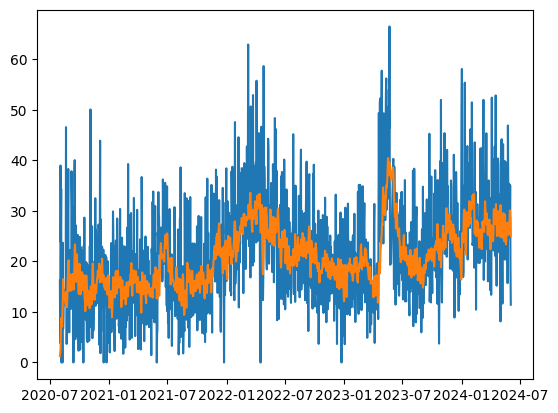

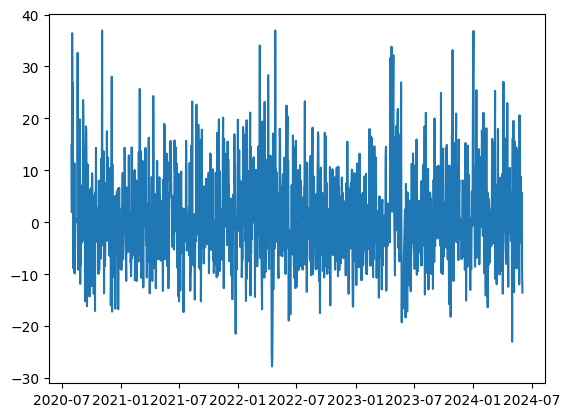

In [5]:
dfid['guess'] = c.value
for (col, beta) in zip(cols, beta_opt):
    dfid['guess'] += beta * dfid[col]

import matplotlib.pyplot as plt
plt.plot(dfid['date'], dfid['sales'])
plt.plot(dfid['date'], dfid['guess'])
plt.show()
plt.plot(dfid['date'], dfid['sales'] - dfid['guess'])

In [6]:
# Holiday kernels
from preprocessing import get_calendar
calendar = get_calendar()
calendar['city'] = calendar['warehouse'].apply(lambda x: x.split('_')[0])
calendar = calendar[['date', 'holiday_name', 'city']].drop_duplicates()
display(calendar)

,date,holiday_name,city
0,2020-08-01,No Holiday,Frankfurt
1,2020-08-01,No Holiday,Prague
2,2020-08-01,No Holiday,Brno
3,2020-08-01,No Holiday,Munich
5,2020-08-01,No Holiday,Budapest
...,...,...,...
11291,2024-12-31,No Holiday,Prague
11292,2024-12-31,No Holiday,Frankfurt
11293,2024-12-31,No Holiday,Budapest
11295,2024-12-31,No Holiday,Munich


In [7]:
holidays = calendar[['date', 'holiday_name']].drop_duplicates()
hcounts = holidays['holiday_name'].value_counts().reset_index()
hcounts = hcounts.loc[hcounts['count'] > 1]
holiday_repeats = hcounts['holiday_name'].unique().tolist()
holiday_repeats.remove('No Holiday')
for _, row in hcounts.iterrows():
    print(f"{row['holiday_name']:60} {row['count']}")

No Holiday                                                   1571
Easter Monday                                                12
Memorial Day for the Victims of the Holocaust                8
Reformation Day                                              5
Peace Festival in Augsburg                                   5
2nd Christmas Day                                            5
1st Christmas Day                                            5
Den boje za svobodu a demokracii                             5
All Saints Day                                               5
Christmas Eve                                                5
Den vzniku samostatneho ceskoslovenskeho statu               5
State Foundation Day                                         5
Memorial Day for the Martyrs of Arad                         5
German Unity Day                                             5
Den ceske statnosti                                          5
Assumption of the Virgin Mary                      

In [8]:
counts = calendar.loc[calendar['holiday_name'].isin(holiday_repeats), 'holiday_name'].value_counts().reset_index()
for _, row in counts.iterrows():
    print(f"{row['holiday_name']:60} {row['count']}")

Easter Monday                                                43
2nd Christmas Day                                            25
1st Christmas Day                                            25
Christmas Eve                                                25
International womens day                                     20
Labour Day                                                   20
New Years Day                                                20
Good Friday                                                  20
Mother Day                                                   16
Whit sunday                                                  12
Whit monday                                                  12
All Saints Day                                               10
Den vzniku samostatneho ceskoslovenskeho statu               10
German Unity Day                                             10
Den ceske statnosti                                          10
Den boje za svobodu a demokracii        

kernel:

$K(t, t_0, s_l, s_r) = $ 

$exp(-(t_0 - t)s_l), t < t_0$

$exp(-(t - t_0)s_r), t \ge t_0$

In [9]:
import cvxpy as cp

def kernel(t, t0, left, right):
    pass

cities = calendar['city'].unique().tolist()
calendar['int_date'] = calendar['date'].astype('int64')/864e11
calendar['int_date'] = calendar['int_date'] - calendar['int_date'].min()
hol_vars = {}
for city in cities:
    city_cal = calendar.loc[calendar['city'] == city]
    display(city_cal)
    holidays = city_cal.loc[city_cal['holiday_name'].isin(holiday_repeats), 'holiday_name'].unique().tolist()
    dates = city_cal.loc[calendar['holiday_name'].isin(holiday_repeats), ['int_date', 'holiday_name']]
    display(dates)
    holiday_date_nums = {}
    for holiday in holidays:
        hol_vars[(city, holiday)] = [cp.Variable(), cp.Variable()]
        int_dates = dates.loc[dates['holiday_name'] == holiday, 'int_date'].to_list()
        print(holiday, int_dates)
        holiday_date_nums[holiday] = int_dates

    

,date,holiday_name,city,int_date
0,2020-08-01,No Holiday,Frankfurt,0.0
8,2020-08-02,No Holiday,Frankfurt,1.0
14,2020-08-03,No Holiday,Frankfurt,2.0
26,2020-08-04,No Holiday,Frankfurt,3.0
31,2020-08-05,No Holiday,Frankfurt,4.0
...,...,...,...,...
11264,2024-12-27,No Holiday,Frankfurt,1609.0
11270,2024-12-28,No Holiday,Frankfurt,1610.0
11281,2024-12-29,No Holiday,Frankfurt,1611.0
11290,2024-12-30,No Holiday,Frankfurt,1612.0


,int_date,holiday_name
441,63.0,German Unity Day
643,91.0,Reformation Day
1016,145.0,Christmas Eve
1025,146.0,1st Christmas Day
1031,147.0,2nd Christmas Day
...,...,...
10670,1524.0,German Unity Day
10868,1552.0,Reformation Day
11243,1606.0,Christmas Eve
11249,1607.0,1st Christmas Day


German Unity Day [63.0, 428.0, 793.0, 1158.0, 1524.0]
Reformation Day [91.0, 456.0, 821.0, 1186.0, 1552.0]
Christmas Eve [145.0, 510.0, 875.0, 1240.0, 1606.0]
1st Christmas Day [146.0, 511.0, 876.0, 1241.0, 1607.0]
2nd Christmas Day [147.0, 512.0, 877.0, 1242.0, 1608.0]
New Years Day [153.0, 518.0, 883.0, 1248.0]
International womens day [219.0, 584.0, 949.0, 1315.0]
Good Friday [244.0, 622.0, 979.0, 1336.0]
Holy Saturday [245.0, 623.0, 980.0, 1337.0]
Easter Monday [246.0, 247.0, 624.0, 625.0, 981.0, 982.0, 1338.0, 1339.0]
Labour Day [273.0, 638.0, 1003.0, 1369.0]
Mother Day [281.0, 645.0, 1016.0, 1380.0]
Ascension day [285.0, 663.0, 1020.0, 1377.0]
Whit sunday [295.0, 673.0, 1030.0, 1387.0]
Whit monday [296.0, 674.0, 1031.0, 1388.0]
Corpus Christi [306.0, 684.0, 1041.0, 1398.0]


,date,holiday_name,city,int_date
1,2020-08-01,No Holiday,Prague,0.0
7,2020-08-02,No Holiday,Prague,1.0
18,2020-08-03,No Holiday,Prague,2.0
21,2020-08-04,No Holiday,Prague,3.0
28,2020-08-05,No Holiday,Prague,4.0
...,...,...,...,...
11265,2024-12-27,No Holiday,Prague,1609.0
11271,2024-12-28,No Holiday,Prague,1610.0
11278,2024-12-29,No Holiday,Prague,1611.0
11285,2024-12-30,No Holiday,Prague,1612.0


,int_date,holiday_name
407,58.0,Den ceske statnosti
617,88.0,Den vzniku samostatneho ceskoslovenskeho statu
757,108.0,Den boje za svobodu a demokracii
1015,145.0,Christmas Eve
1023,146.0,1st Christmas Day
...,...,...
10843,1549.0,Den vzniku samostatneho ceskoslovenskeho statu
10986,1569.0,Den boje za svobodu a demokracii
11242,1606.0,Christmas Eve
11252,1607.0,1st Christmas Day


Den ceske statnosti [58.0, 423.0, 788.0, 1153.0, 1519.0]
Den vzniku samostatneho ceskoslovenskeho statu [88.0, 453.0, 818.0, 1183.0, 1549.0]
Den boje za svobodu a demokracii [108.0, 473.0, 838.0, 1203.0, 1569.0]
Christmas Eve [145.0, 510.0, 875.0, 1240.0, 1606.0]
1st Christmas Day [146.0, 511.0, 876.0, 1241.0, 1607.0]
2nd Christmas Day [147.0, 512.0, 877.0, 1242.0, 1608.0]
New Years Day [153.0, 518.0, 883.0, 1248.0]
International womens day [219.0, 584.0, 949.0, 1315.0]
Good Friday [244.0, 622.0, 979.0, 1336.0]
Easter Monday [245.0, 247.0, 623.0, 625.0, 980.0, 982.0, 1337.0, 1339.0]
Easter Day [246.0, 624.0, 981.0, 1338.0]
Labour Day [273.0, 638.0, 1003.0, 1369.0]
Den osvobozeni [280.0, 1010.0, 1376.0]
Mother Day [281.0, 645.0, 1016.0, 1380.0]
Cyrila a Metodej [338.0, 703.0, 1068.0, 1434.0]
Jan Hus [339.0, 704.0, 1069.0, 1435.0]


,date,holiday_name,city,int_date
2,2020-08-01,No Holiday,Brno,0.0
10,2020-08-02,No Holiday,Brno,1.0
15,2020-08-03,No Holiday,Brno,2.0
22,2020-08-04,No Holiday,Brno,3.0
29,2020-08-05,No Holiday,Brno,4.0
...,...,...,...,...
11268,2024-12-27,No Holiday,Brno,1609.0
11276,2024-12-28,No Holiday,Brno,1610.0
11277,2024-12-29,No Holiday,Brno,1611.0
11288,2024-12-30,No Holiday,Brno,1612.0


,int_date,holiday_name
408,58.0,Den ceske statnosti
618,88.0,Den vzniku samostatneho ceskoslovenskeho statu
762,108.0,Den boje za svobodu a demokracii
1021,145.0,Christmas Eve
1027,146.0,1st Christmas Day
...,...,...
10849,1549.0,Den vzniku samostatneho ceskoslovenskeho statu
10985,1569.0,Den boje za svobodu a demokracii
11247,1606.0,Christmas Eve
11250,1607.0,1st Christmas Day


Den ceske statnosti [58.0, 423.0, 788.0, 1153.0, 1519.0]
Den vzniku samostatneho ceskoslovenskeho statu [88.0, 453.0, 818.0, 1183.0, 1549.0]
Den boje za svobodu a demokracii [108.0, 473.0, 838.0, 1203.0, 1569.0]
Christmas Eve [145.0, 510.0, 875.0, 1240.0, 1606.0]
1st Christmas Day [146.0, 511.0, 876.0, 1241.0, 1607.0]
2nd Christmas Day [147.0, 512.0, 877.0, 1242.0, 1608.0]
New Years Day [153.0, 518.0, 883.0, 1248.0]
International womens day [219.0, 584.0, 949.0, 1315.0]
Good Friday [244.0, 622.0, 979.0, 1336.0]
Easter Monday [245.0, 247.0, 623.0, 625.0, 980.0, 982.0, 1337.0, 1339.0]
Easter Day [246.0, 624.0, 981.0, 1338.0]
Labour Day [273.0, 638.0, 1003.0, 1369.0]
Den osvobozeni [280.0, 1010.0, 1376.0]
Mother Day [281.0, 645.0, 1016.0, 1380.0]
Cyrila a Metodej [338.0, 703.0, 1068.0, 1434.0]
Jan Hus [339.0, 704.0, 1069.0, 1435.0]


,date,holiday_name,city,int_date
3,2020-08-01,No Holiday,Munich,0.0
13,2020-08-02,No Holiday,Munich,1.0
16,2020-08-03,No Holiday,Munich,2.0
27,2020-08-04,No Holiday,Munich,3.0
33,2020-08-05,No Holiday,Munich,4.0
...,...,...,...,...
11263,2024-12-27,No Holiday,Munich,1609.0
11272,2024-12-28,No Holiday,Munich,1610.0
11282,2024-12-29,No Holiday,Munich,1611.0
11287,2024-12-30,No Holiday,Munich,1612.0


,int_date,holiday_name
50,7.0,Peace Festival in Augsburg
101,14.0,Assumption of the Virgin Mary
445,63.0,German Unity Day
647,92.0,All Saints Day
1018,145.0,Christmas Eve
...,...,...
10669,1524.0,German Unity Day
10877,1553.0,All Saints Day
11244,1606.0,Christmas Eve
11253,1607.0,1st Christmas Day


Peace Festival in Augsburg [7.0, 372.0, 737.0, 1102.0, 1468.0]
Assumption of the Virgin Mary [14.0, 379.0, 744.0, 1109.0, 1475.0]
German Unity Day [63.0, 428.0, 793.0, 1158.0, 1524.0]
All Saints Day [92.0, 457.0, 822.0, 1187.0, 1553.0]
Christmas Eve [145.0, 510.0, 875.0, 1240.0, 1606.0]
1st Christmas Day [146.0, 511.0, 876.0, 1241.0, 1607.0]
2nd Christmas Day [147.0, 512.0, 877.0, 1242.0, 1608.0]
New Years Day [153.0, 518.0, 883.0, 1248.0]
Epiphany [158.0, 523.0, 888.0, 1253.0]
International womens day [219.0, 584.0, 949.0, 1315.0]
Good Friday [244.0, 622.0, 979.0, 1336.0]
Holy Saturday [245.0, 623.0, 980.0, 1337.0]
Easter Monday [246.0, 247.0, 624.0, 625.0, 981.0, 982.0, 1338.0, 1339.0]
Labour Day [273.0, 638.0, 1003.0, 1369.0]
Mother Day [281.0, 645.0, 1016.0, 1380.0]
Ascension day [285.0, 663.0, 1020.0, 1377.0]
Whit sunday [295.0, 673.0, 1030.0, 1387.0]
Whit monday [296.0, 674.0, 1031.0, 1388.0]
Corpus Christi [306.0, 684.0, 1041.0, 1398.0]


,date,holiday_name,city,int_date
5,2020-08-01,No Holiday,Budapest,0.0
12,2020-08-02,No Holiday,Budapest,1.0
17,2020-08-03,No Holiday,Budapest,2.0
24,2020-08-04,No Holiday,Budapest,3.0
34,2020-08-05,No Holiday,Budapest,4.0
...,...,...,...,...
11267,2024-12-27,No Holiday,Budapest,1609.0
11273,2024-12-28,No Holiday,Budapest,1610.0
11280,2024-12-29,No Holiday,Budapest,1611.0
11284,2024-12-30,No Holiday,Budapest,1612.0


,int_date,holiday_name
133,19.0,State Foundation Day
468,66.0,Memorial Day for the Martyrs of Arad
582,83.0,Memorial day of the 1956 Revolution
649,92.0,All Saints Day
1020,145.0,Christmas Eve
...,...,...
10813,1544.0,Memorial day of the 1956 Revolution
10871,1553.0,All Saints Day
11246,1606.0,Christmas Eve
11251,1607.0,1st Christmas Day


State Foundation Day [19.0, 384.0, 749.0, 1114.0, 1480.0]
Memorial Day for the Martyrs of Arad [66.0, 431.0, 796.0, 1161.0, 1527.0]
Memorial day of the 1956 Revolution [83.0, 448.0, 813.0, 1178.0, 1544.0]
All Saints Day [92.0, 457.0, 822.0, 1187.0, 1553.0]
Christmas Eve [145.0, 510.0, 875.0, 1240.0, 1606.0]
1st Christmas Day [146.0, 511.0, 876.0, 1241.0, 1607.0]
2nd Christmas Day [147.0, 512.0, 877.0, 1242.0, 1608.0]
New Years Day [153.0, 518.0, 883.0, 1248.0]
Memorial Day of the Republic [184.0, 549.0, 914.0, 1279.0]
Memorial Day for the Victims of the Communist Dictatorships [208.0, 573.0, 938.0, 1303.0]
International womens day [219.0, 584.0, 949.0, 1315.0]
Memorial Day for the Victims of the Holocaust [226.0, 258.0, 591.0, 623.0, 956.0, 988.0, 1322.0, 1354.0]
Good Friday [244.0, 622.0, 979.0, 1336.0]
Easter Monday [245.0, 246.0, 247.0, 624.0, 625.0, 980.0, 981.0, 982.0, 1337.0, 1338.0, 1339.0]
Labour Day [273.0, 638.0, 1003.0, 1369.0]
National Defense Day [293.0, 658.0, 1023.0, 138

In [1]:
from convex import get_dataframe
df = get_dataframe('Prague')
display(df)

           date          sales         moving     week_trend         lag_14  \
0    2020-08-01  218887.524942  318902.771112  304561.690966       0.000000   
1    2020-08-02  251716.296300  323862.548109  318082.268296       0.000000   
2    2020-08-03  250795.975170  325588.784838  336635.640221       0.000000   
3    2020-08-04  230188.600293  330116.062295  323052.059452       0.000000   
4    2020-08-05  222581.740432  326637.863836  321438.017461       0.000000   
...         ...            ...            ...            ...            ...   
1397 2024-05-29  448941.235802  501641.948988  463502.152254  458752.619530   
1398 2024-05-30  507106.516853  507968.889648  518031.122806  537054.606417   
1399 2024-05-31  586558.825144  519003.339263  625528.366318  593286.244543   
1400 2024-06-01  472504.132178  517488.771686  506117.806386  505984.402795   
1401 2024-06-02  445615.877355  508768.040048  500595.688498  489749.451060   

             lag_21         lag_28         lag_35  

,sales,moving,week_trend,lag_14,lag_21,lag_28,lag_35,lag_42,normed_week_mean,normed_week_median,total_orders,holiday_name,int_date,cos_weekday,sin_weekday
0,218887.524942,318902.771112,304561.690966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9823.211976,Blank,0.0,-0.222521,-0.974928
1,251716.296300,323862.548109,318082.268296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11128.628510,Blank,1.0,0.623490,-0.781831
2,250795.975170,325588.784838,336635.640221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11652.649439,Blank,2.0,1.000000,0.000000
3,230188.600293,330116.062295,323052.059452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11587.837937,Blank,3.0,0.623490,0.781831
4,222581.740432,326637.863836,321438.017461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11500.220320,Blank,4.0,-0.222521,0.974928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,448941.235802,501641.948988,463502.152254,458752.619530,429707.860417,453055.489951,427085.436186,441023.469298,444729.582485,385787.895805,27017.699488,Blank,1397.0,-0.222521,0.974928
1398,507106.516853,507968.889648,518031.122806,537054.606417,492739.300310,511223.530547,512595.743322,510972.795228,516940.097040,452320.899747,29782.089172,Blank,1398.0,-0.900969,0.433884
1399,586558.825144,519003.339263,625528.366318,593286.244543,570361.832071,595236.089790,593911.303090,573848.946484,586655.110087,515303.169165,32112.800215,Blank,1399.0,-0.900969,-0.433884
1400,472504.132178,517488.771686,506117.806386,505984.402795,481707.222802,486422.333917,497565.568944,493703.226367,495227.859603,439339.938045,27203.740195,Blank,1400.0,-0.222521,-0.974928


In [2]:
df['holiday_name'].unique().tolist()

['Blank',
 'Den ceske statnosti',
 'Den vzniku samostatneho ceskoslovenskeho statu',
 'Den boje za svobodu a demokracii',
 'Christmas Eve',
 '1st Christmas Day',
 '2nd Christmas Day',
 'New Years Day',
 'International womens day',
 'Good Friday',
 'Easter Monday',
 'Easter Day',
 'Labour Day',
 'Den osvobozeni',
 'Mother Day',
 'Cyrila a Metodej',
 'Jan Hus']

In [1]:
from convex import Convex
cvx = Convex('Prague')
cvx.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
abs(param1 + -param2 @ var3 + -Hstack(param36 + Vstack(exp(Promote(var4, (58, 1)) @ param37), exp(Promote(var5, (1344, 1)) @ param41)) + Vstack(exp(Promote(var4, (423, 1)) @ param47), exp(Promote(var5, (979, 1)) @ param51)) + Vstack(exp(Promote(var4, (788, 1)) @ param57), exp(Promote(var5, (614, 1)) @ param61)) + Vstack(exp(Promote(var4, (1153, 1)) @ param67), exp(Promote(var5, (249, 1)) @ param71)), param77 + Vstack(exp(Promote(var6, (88, 1)) @ param78), exp(Promote(var7, (1314, 1)) @ param82)) + Vstack(exp(Promote(var6, (453, 1)) @ param88), exp(Promote(var7, (949, 1)) @ param92)) + Vstack(exp(Promote(var6, (818, 1)) @ param98), exp(Promote(var7, (584, 1)) @ param102)) + Vstack(exp(Promote(var6, (1183, 1)) @ param108), exp(Promote(var7, (219, 1)) @ param112)), param118 + Vstack(exp(Promote(var8, (108, 1)) @ param119), exp(Promote(var9, (1294, 1)) @ param123)) + Vstack(exp(Promote(var8, (473, 1)) @ param129), exp(Promote(var9, (929, 1)) @ param133)) + Vstack(exp(Promote(var8, (838, 1)) @ param139), exp(Promote(var9, (564, 1)) @ param143)) + Vstack(exp(Promote(var8, (1203, 1)) @ param149), exp(Promote(var9, (199, 1)) @ param153)), param159 + Vstack(exp(Promote(var10, (145, 1)) @ param160), exp(Promote(var11, (1257, 1)) @ param164)) + Vstack(exp(Promote(var10, (510, 1)) @ param170), exp(Promote(var11, (892, 1)) @ param174)) + Vstack(exp(Promote(var10, (875, 1)) @ param180), exp(Promote(var11, (527, 1)) @ param184)) + Vstack(exp(Promote(var10, (1240, 1)) @ param190), exp(Promote(var11, (162, 1)) @ param194)), param200 + Vstack(exp(Promote(var12, (146, 1)) @ param201), exp(Promote(var13, (1256, 1)) @ param205)) + Vstack(exp(Promote(var12, (511, 1)) @ param211), exp(Promote(var13, (891, 1)) @ param215)) + Vstack(exp(Promote(var12, (876, 1)) @ param221), exp(Promote(var13, (526, 1)) @ param225)) + Vstack(exp(Promote(var12, (1241, 1)) @ param231), exp(Promote(var13, (161, 1)) @ param235)), param241 + Vstack(exp(Promote(var14, (147, 1)) @ param242), exp(Promote(var15, (1255, 1)) @ param246)) + Vstack(exp(Promote(var14, (512, 1)) @ param252), exp(Promote(var15, (890, 1)) @ param256)) + Vstack(exp(Promote(var14, (877, 1)) @ param262), exp(Promote(var15, (525, 1)) @ param266)) + Vstack(exp(Promote(var14, (1242, 1)) @ param272), exp(Promote(var15, (160, 1)) @ param276)), param282 + Vstack(exp(Promote(var16, (153, 1)) @ param283), exp(Promote(var17, (1249, 1)) @ param287)) + Vstack(exp(Promote(var16, (518, 1)) @ param293), exp(Promote(var17, (884, 1)) @ param297)) + Vstack(exp(Promote(var16, (883, 1)) @ param303), exp(Promote(var17, (519, 1)) @ param307)) + Vstack(exp(Promote(var16, (1248, 1)) @ param313), exp(Promote(var17, (154, 1)) @ param317)), param323 + Vstack(exp(Promote(var18, (219, 1)) @ param324), exp(Promote(var19, (1183, 1)) @ param328)) + Vstack(exp(Promote(var18, (584, 1)) @ param334), exp(Promote(var19, (818, 1)) @ param338)) + Vstack(exp(Promote(var18, (949, 1)) @ param344), exp(Promote(var19, (453, 1)) @ param348)) + Vstack(exp(Promote(var18, (1315, 1)) @ param354), exp(Promote(var19, (87, 1)) @ param358)), param364 + Vstack(exp(Promote(var20, (244, 1)) @ param365), exp(Promote(var21, (1158, 1)) @ param369)) + Vstack(exp(Promote(var20, (622, 1)) @ param375), exp(Promote(var21, (780, 1)) @ param379)) + Vstack(exp(Promote(var20, (979, 1)) @ param385), exp(Promote(var21, (423, 1)) @ param389)) + Vstack(exp(Promote(var20, (1336, 1)) @ param395), exp(Promote(var21, (66, 1)) @ param399)), param405 + Vstack(exp(Promote(var22, (245, 1)) @ param406), exp(Promote(var23, (1157, 1)) @ param410)) + Vstack(exp(Promote(var22, (247, 1)) @ param416), exp(Promote(var23, (1155, 1)) @ param420)) + Vstack(exp(Promote(var22, (623, 1)) @ param426), exp(Promote(var23, (779, 1)) @ param430)) + Vstack(exp(Promote(var22, (625, 1)) @ param436), exp(Promote(var23, (777, 1)) @ param440)) + Vstack(exp(Promote(var22, (980, 1)) @ param446), exp(Promote(var23, (422, 1)) @ param450)) + Vstack(exp(Promote(var22, (982, 1)) @ param456), exp(Promote(var23, (420, 1)) @ param460)) + Vstack(exp(Promote(var22, (1337, 1)) @ param466), exp(Promote(var23, (65, 1)) @ param470)) + Vstack(exp(Promote(var22, (1339, 1)) @ param476), exp(Promote(var23, (63, 1)) @ param480)), param486 + Vstack(exp(Promote(var24, (246, 1)) @ param487), exp(Promote(var25, (1156, 1)) @ param491)) + Vstack(exp(Promote(var24, (624, 1)) @ param497), exp(Promote(var25, (778, 1)) @ param501)) + Vstack(exp(Promote(var24, (981, 1)) @ param507), exp(Promote(var25, (421, 1)) @ param511)) + Vstack(exp(Promote(var24, (1338, 1)) @ param517), exp(Promote(var25, (64, 1)) @ param521)), param527 + Vstack(exp(Promote(var26, (273, 1)) @ param528), exp(Promote(var27, (1129, 1)) @ param532)) + Vstack(exp(Promote(var26, (638, 1)) @ param538), exp(Promote(var27, (764, 1)) @ param542)) + Vstack(exp(Promote(var26, (1003, 1)) @ param548), exp(Promote(var27, (399, 1)) @ param552)) + Vstack(exp(Promote(var26, (1369, 1)) @ param558), exp(Promote(var27, (33, 1)) @ param562)), param568 + Vstack(exp(Promote(var28, (280, 1)) @ param569), exp(Promote(var29, (1122, 1)) @ param573)) + Vstack(exp(Promote(var28, (1010, 1)) @ param579), exp(Promote(var29, (392, 1)) @ param583)) + Vstack(exp(Promote(var28, (1376, 1)) @ param589), exp(Promote(var29, (26, 1)) @ param593)), param599 + Vstack(exp(Promote(var30, (281, 1)) @ param600), exp(Promote(var31, (1121, 1)) @ param604)) + Vstack(exp(Promote(var30, (645, 1)) @ param610), exp(Promote(var31, (757, 1)) @ param614)) + Vstack(exp(Promote(var30, (1016, 1)) @ param620), exp(Promote(var31, (386, 1)) @ param624)) + Vstack(exp(Promote(var30, (1380, 1)) @ param630), exp(Promote(var31, (22, 1)) @ param634)), param640 + Vstack(exp(Promote(var32, (338, 1)) @ param641), exp(Promote(var33, (1064, 1)) @ param645)) + Vstack(exp(Promote(var32, (703, 1)) @ param651), exp(Promote(var33, (699, 1)) @ param655)) + Vstack(exp(Promote(var32, (1068, 1)) @ param661), exp(Promote(var33, (334, 1)) @ param665)), param671 + Vstack(exp(Promote(var34, (339, 1)) @ param672), exp(Promote(var35, (1063, 1)) @ param676)) + Vstack(exp(Promote(var34, (704, 1)) @ param682), exp(Promote(var35, (698, 1)) @ param686)) + Vstack(exp(Promote(var34, (1069, 1)) @ param692), exp(Promote(var35, (333, 1)) @ param696))) @ var705 + -Promote(var703, (1402, 1)) @ param712) <= var704 , because the following subexpressions are not:
|--  Hstack(param36 + Vstack(exp(Promote(var4, (58, 1)) @ param37), exp(Promote(var5, (1344, 1)) @ param41)) + Vstack(exp(Promote(var4, (423, 1)) @ param47), exp(Promote(var5, (979, 1)) @ param51)) + Vstack(exp(Promote(var4, (788, 1)) @ param57), exp(Promote(var5, (614, 1)) @ param61)) + Vstack(exp(Promote(var4, (1153, 1)) @ param67), exp(Promote(var5, (249, 1)) @ param71)), param77 + Vstack(exp(Promote(var6, (88, 1)) @ param78), exp(Promote(var7, (1314, 1)) @ param82)) + Vstack(exp(Promote(var6, (453, 1)) @ param88), exp(Promote(var7, (949, 1)) @ param92)) + Vstack(exp(Promote(var6, (818, 1)) @ param98), exp(Promote(var7, (584, 1)) @ param102)) + Vstack(exp(Promote(var6, (1183, 1)) @ param108), exp(Promote(var7, (219, 1)) @ param112)), param118 + Vstack(exp(Promote(var8, (108, 1)) @ param119), exp(Promote(var9, (1294, 1)) @ param123)) + Vstack(exp(Promote(var8, (473, 1)) @ param129), exp(Promote(var9, (929, 1)) @ param133)) + Vstack(exp(Promote(var8, (838, 1)) @ param139), exp(Promote(var9, (564, 1)) @ param143)) + Vstack(exp(Promote(var8, (1203, 1)) @ param149), exp(Promote(var9, (199, 1)) @ param153)), param159 + Vstack(exp(Promote(var10, (145, 1)) @ param160), exp(Promote(var11, (1257, 1)) @ param164)) + Vstack(exp(Promote(var10, (510, 1)) @ param170), exp(Promote(var11, (892, 1)) @ param174)) + Vstack(exp(Promote(var10, (875, 1)) @ param180), exp(Promote(var11, (527, 1)) @ param184)) + Vstack(exp(Promote(var10, (1240, 1)) @ param190), exp(Promote(var11, (162, 1)) @ param194)), param200 + Vstack(exp(Promote(var12, (146, 1)) @ param201), exp(Promote(var13, (1256, 1)) @ param205)) + Vstack(exp(Promote(var12, (511, 1)) @ param211), exp(Promote(var13, (891, 1)) @ param215)) + Vstack(exp(Promote(var12, (876, 1)) @ param221), exp(Promote(var13, (526, 1)) @ param225)) + Vstack(exp(Promote(var12, (1241, 1)) @ param231), exp(Promote(var13, (161, 1)) @ param235)), param241 + Vstack(exp(Promote(var14, (147, 1)) @ param242), exp(Promote(var15, (1255, 1)) @ param246)) + Vstack(exp(Promote(var14, (512, 1)) @ param252), exp(Promote(var15, (890, 1)) @ param256)) + Vstack(exp(Promote(var14, (877, 1)) @ param262), exp(Promote(var15, (525, 1)) @ param266)) + Vstack(exp(Promote(var14, (1242, 1)) @ param272), exp(Promote(var15, (160, 1)) @ param276)), param282 + Vstack(exp(Promote(var16, (153, 1)) @ param283), exp(Promote(var17, (1249, 1)) @ param287)) + Vstack(exp(Promote(var16, (518, 1)) @ param293), exp(Promote(var17, (884, 1)) @ param297)) + Vstack(exp(Promote(var16, (883, 1)) @ param303), exp(Promote(var17, (519, 1)) @ param307)) + Vstack(exp(Promote(var16, (1248, 1)) @ param313), exp(Promote(var17, (154, 1)) @ param317)), param323 + Vstack(exp(Promote(var18, (219, 1)) @ param324), exp(Promote(var19, (1183, 1)) @ param328)) + Vstack(exp(Promote(var18, (584, 1)) @ param334), exp(Promote(var19, (818, 1)) @ param338)) + Vstack(exp(Promote(var18, (949, 1)) @ param344), exp(Promote(var19, (453, 1)) @ param348)) + Vstack(exp(Promote(var18, (1315, 1)) @ param354), exp(Promote(var19, (87, 1)) @ param358)), param364 + Vstack(exp(Promote(var20, (244, 1)) @ param365), exp(Promote(var21, (1158, 1)) @ param369)) + Vstack(exp(Promote(var20, (622, 1)) @ param375), exp(Promote(var21, (780, 1)) @ param379)) + Vstack(exp(Promote(var20, (979, 1)) @ param385), exp(Promote(var21, (423, 1)) @ param389)) + Vstack(exp(Promote(var20, (1336, 1)) @ param395), exp(Promote(var21, (66, 1)) @ param399)), param405 + Vstack(exp(Promote(var22, (245, 1)) @ param406), exp(Promote(var23, (1157, 1)) @ param410)) + Vstack(exp(Promote(var22, (247, 1)) @ param416), exp(Promote(var23, (1155, 1)) @ param420)) + Vstack(exp(Promote(var22, (623, 1)) @ param426), exp(Promote(var23, (779, 1)) @ param430)) + Vstack(exp(Promote(var22, (625, 1)) @ param436), exp(Promote(var23, (777, 1)) @ param440)) + Vstack(exp(Promote(var22, (980, 1)) @ param446), exp(Promote(var23, (422, 1)) @ param450)) + Vstack(exp(Promote(var22, (982, 1)) @ param456), exp(Promote(var23, (420, 1)) @ param460)) + Vstack(exp(Promote(var22, (1337, 1)) @ param466), exp(Promote(var23, (65, 1)) @ param470)) + Vstack(exp(Promote(var22, (1339, 1)) @ param476), exp(Promote(var23, (63, 1)) @ param480)), param486 + Vstack(exp(Promote(var24, (246, 1)) @ param487), exp(Promote(var25, (1156, 1)) @ param491)) + Vstack(exp(Promote(var24, (624, 1)) @ param497), exp(Promote(var25, (778, 1)) @ param501)) + Vstack(exp(Promote(var24, (981, 1)) @ param507), exp(Promote(var25, (421, 1)) @ param511)) + Vstack(exp(Promote(var24, (1338, 1)) @ param517), exp(Promote(var25, (64, 1)) @ param521)), param527 + Vstack(exp(Promote(var26, (273, 1)) @ param528), exp(Promote(var27, (1129, 1)) @ param532)) + Vstack(exp(Promote(var26, (638, 1)) @ param538), exp(Promote(var27, (764, 1)) @ param542)) + Vstack(exp(Promote(var26, (1003, 1)) @ param548), exp(Promote(var27, (399, 1)) @ param552)) + Vstack(exp(Promote(var26, (1369, 1)) @ param558), exp(Promote(var27, (33, 1)) @ param562)), param568 + Vstack(exp(Promote(var28, (280, 1)) @ param569), exp(Promote(var29, (1122, 1)) @ param573)) + Vstack(exp(Promote(var28, (1010, 1)) @ param579), exp(Promote(var29, (392, 1)) @ param583)) + Vstack(exp(Promote(var28, (1376, 1)) @ param589), exp(Promote(var29, (26, 1)) @ param593)), param599 + Vstack(exp(Promote(var30, (281, 1)) @ param600), exp(Promote(var31, (1121, 1)) @ param604)) + Vstack(exp(Promote(var30, (645, 1)) @ param610), exp(Promote(var31, (757, 1)) @ param614)) + Vstack(exp(Promote(var30, (1016, 1)) @ param620), exp(Promote(var31, (386, 1)) @ param624)) + Vstack(exp(Promote(var30, (1380, 1)) @ param630), exp(Promote(var31, (22, 1)) @ param634)), param640 + Vstack(exp(Promote(var32, (338, 1)) @ param641), exp(Promote(var33, (1064, 1)) @ param645)) + Vstack(exp(Promote(var32, (703, 1)) @ param651), exp(Promote(var33, (699, 1)) @ param655)) + Vstack(exp(Promote(var32, (1068, 1)) @ param661), exp(Promote(var33, (334, 1)) @ param665)), param671 + Vstack(exp(Promote(var34, (339, 1)) @ param672), exp(Promote(var35, (1063, 1)) @ param676)) + Vstack(exp(Promote(var34, (704, 1)) @ param682), exp(Promote(var35, (698, 1)) @ param686)) + Vstack(exp(Promote(var34, (1069, 1)) @ param692), exp(Promote(var35, (333, 1)) @ param696))) @ var705